## Clasificadores

In [1]:
%matplotlib inline

from sentiment.tass import InterTASSReader, GeneralTASSReader
from sentiment.baselines import MostFrequent
from sentiment.classifier import SentimentClassifier
from sentiment.evaluator import Evaluator
import pandas as pd

pd.options.display.precision = 3

    
def learning_curve(model, X, y, X_cv, y_cv): 
    """
    Learning Curve of the model
    
    Returns ns, acc_curve, f1_curve
    """
    N = len(X)
    acc_curve = []
    evaluator = Evaluator()
    f1_curve = []
    ns = []
    for i in reversed(range(8)):
        n = int(N / 2**i)
        this_X = X[:n]
        this_y = y[:n]

        # train, test and evaluate
        model.fit(this_X, this_y)
        y_pred = model.predict(X_cv)
        evaluator.evaluate(y_cv, y_pred)

        # print this data point:
        acc = evaluator.accuracy()
        f1 = evaluator.macro_f1()
        
        acc_curve.append(acc)
        f1_curve.append(f1)
        ns.append(n)
    return ns, acc_curve, f1_curve
        
# load corpora
reader1 = InterTASSReader('../data/TASS/InterTASS/tw_faces4tassTrain1000rc.xml')
X1, y1 = list(reader1.X()), list(reader1.y())
reader2 = GeneralTASSReader('../data/TASS/GeneralTASS/general-tweets-train-tagged.xml', simple=True)
X2, y2 = list(reader2.X()), list(reader2.y())
X, y = X1 + X2, y1 + y2

reader_cv = InterTASSReader('../data/TASS/InterTASS/TASS2017_T1_development.xml')
X_cv, y_cv = list(reader_cv.X()), list(reader_cv.y())


## Sin tokenizador

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import TweetTokenizer
from collections import defaultdict


clf_classes = [
    ('MaxEnt', LogisticRegression), 
    ('MNB', MultinomialNB), 
    ('SVM', LinearSVC)
]

analysis = {}


def do_full_analysis(base_steps, clf_classes, full_name, print_results=True):
    sns.set_style("darkgrid")

    acc_curves = {}
    f1_curves = {}
    ret = {}
    

    for name, clf_class in clf_classes:
        model = Pipeline(base_steps + [('clf', clf_class())])

        model.fit(X, y)

        y_pred = model.predict(X_cv)
        evaluator = Evaluator()
        evaluator.evaluate(y_cv, y_pred)
        if print_results:
            print("=" * 80)
            print(name)
      
            evaluator.print_results()
            evaluator.print_confusion_matrix()

        ns, acc_curve, f1_curve = learning_curve(model, X, y, X_cv, y_cv)
        acc_curves[name] = acc_curve
        f1_curves[name] = f1_curve
        
        ret["{}_{}".format(full_name, name)] = {
            "accuracy": evaluator.accuracy(),
            "macro-precision": evaluator.macro_prec(),
            "macro-recall": evaluator.macro_rec(),
            "macro-f1": evaluator.macro_f1()
        }

    ax1 = pd.DataFrame(acc_curves, index=ns).plot(title="{} Accuracy Learning Curves".format(full_name))
    plt.savefig("images/{}_acc.png".format(full_name))
    ax2 = pd.DataFrame(f1_curves, index=ns).plot(title="{} F1 Learning Curves".format(full_name))
    plt.savefig("images/{}_f1.png".format(full_name))
    return ret

MaxEnt
Sentiment P:
  Precision: 52.89% (119/225)
  Recall: 76.28% (119/156)
  F1: 62.47%
Sentiment N:
  Precision: 60.65% (131/216)
  Recall: 59.82% (131/219)
  F1: 60.23%
Sentiment NEU:
  Precision: 15.79% (3/19)
  Recall: 4.35% (3/69)
  F1: 6.82%
Sentiment NONE:
  Precision: 28.26% (13/46)
  Recall: 20.97% (13/62)
  F1: 24.07%
Accuracy: 52.57% (266/506)
Macro-Precision: 39.40%
Macro-Recall: 40.35%
Macro-F1: 39.87%
	P	N	NEU	NONE
P	119	27	5	5	
N	60	131	7	21	
NEU	30	29	3	7	
NONE	16	29	4	13	
MNB
Sentiment P:
  Precision: 49.22% (127/258)
  Recall: 81.41% (127/156)
  F1: 61.35%
Sentiment N:
  Precision: 58.61% (143/244)
  Recall: 65.30% (143/219)
  F1: 61.77%
Sentiment NEU:
  Precision: 0.00% (0/1)
  Recall: 0.00% (0/69)
  F1: 0.00%
Sentiment NONE:
  Precision: 66.67% (2/3)
  Recall: 3.23% (2/62)
  F1: 6.15%
Accuracy: 53.75% (272/506)
Macro-Precision: 43.62%
Macro-Recall: 37.48%
Macro-F1: 40.32%
	P	N	NEU	NONE
P	127	28	1	0	
N	75	143	0	1	
NEU	35	34	0	0	
NONE	21	39	0	2	
SVM
Sentiment P:
  P

,base_MNB,base_MaxEnt,base_SVM
accuracy,53.755,52.569,50.395
macro-f1,40.321,39.870,40.022
macro-precision,43.625,39.397,39.157
macro-recall,37.483,40.354,40.926


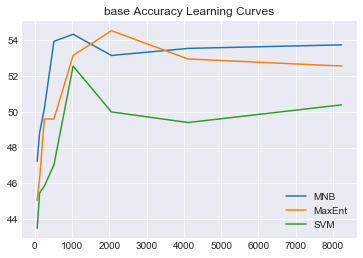

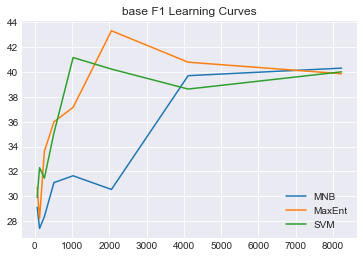

In [3]:
base_steps = [
    ('vect', CountVectorizer())
]

analysis.update(do_full_analysis(base_steps, clf_classes, "base"))

pd.DataFrame(analysis)

## Con Tweet Tokenizer

MaxEnt
Sentiment P:
  Precision: 53.30% (105/197)
  Recall: 67.31% (105/156)
  F1: 59.49%
Sentiment N:
  Precision: 62.04% (134/216)
  Recall: 61.19% (134/219)
  F1: 61.61%
Sentiment NEU:
  Precision: 29.41% (5/17)
  Recall: 7.25% (5/69)
  F1: 11.63%
Sentiment NONE:
  Precision: 21.05% (16/76)
  Recall: 25.81% (16/62)
  F1: 23.19%
Accuracy: 51.38% (260/506)
Macro-Precision: 41.45%
Macro-Recall: 40.39%
Macro-F1: 40.91%
	P	N	NEU	NONE
P	105	26	7	18	
N	53	134	3	29	
NEU	24	27	5	13	
NONE	15	29	2	16	
MNB
Sentiment P:
  Precision: 51.61% (128/248)
  Recall: 82.05% (128/156)
  F1: 63.37%
Sentiment N:
  Precision: 58.20% (149/256)
  Recall: 68.04% (149/219)
  F1: 62.74%
Sentiment NEU:
  Precision: 0.00% (0/0)
  Recall: 0.00% (0/69)
  F1: 0.00%
Sentiment NONE:
  Precision: 100.00% (2/2)
  Recall: 3.23% (2/62)
  F1: 6.25%
Accuracy: 55.14% (279/506)
Macro-Precision: 52.45%
Macro-Recall: 38.33%
Macro-F1: 44.29%
	P	N	NEU	NONE
P	128	28	0	0	
N	70	149	0	0	
NEU	28	41	0	0	
NONE	22	38	0	2	
SVM
Sentiment P:

,base_MNB,base_MaxEnt,base_SVM,tw_tknzr_MNB,tw_tknzr_MaxEnt,tw_tknzr_SVM
accuracy,53.755,52.569,50.395,55.138,51.383,49.407
macro-f1,40.321,39.870,40.022,44.292,40.912,39.451
macro-precision,43.625,39.397,39.157,52.454,41.450,38.750
macro-recall,37.483,40.354,40.926,38.328,40.387,40.176


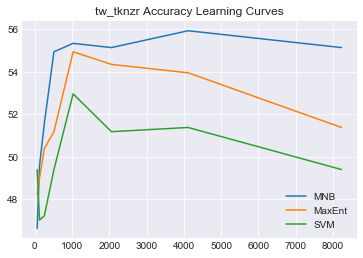

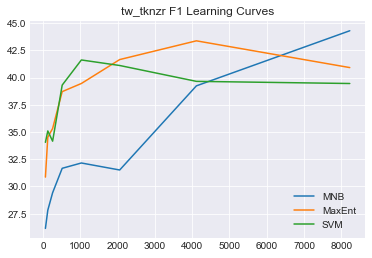

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
base_steps = [
    ('vect', CountVectorizer(tokenizer=tokenizer.tokenize)),
]

name = "tw_tknzr"

analysis.update(do_full_analysis(base_steps, clf_classes, name))


pd.DataFrame(analysis)

## Tokenizador+Normalizador

MaxEnt
Sentiment P:
  Precision: 52.22% (106/203)
  Recall: 67.95% (106/156)
  F1: 59.05%
Sentiment N:
  Precision: 62.80% (130/207)
  Recall: 59.36% (130/219)
  F1: 61.03%
Sentiment NEU:
  Precision: 27.78% (5/18)
  Recall: 7.25% (5/69)
  F1: 11.49%
Sentiment NONE:
  Precision: 21.79% (17/78)
  Recall: 27.42% (17/62)
  F1: 24.29%
Accuracy: 50.99% (258/506)
Macro-Precision: 41.15%
Macro-Recall: 40.49%
Macro-F1: 40.82%
	P	N	NEU	NONE
P	106	26	6	18	
N	53	130	5	31	
NEU	26	26	5	12	
NONE	18	25	2	17	
MNB
Sentiment P:
  Precision: 50.00% (129/258)
  Recall: 82.69% (129/156)
  F1: 62.32%
Sentiment N:
  Precision: 59.02% (144/244)
  Recall: 65.75% (144/219)
  F1: 62.20%
Sentiment NEU:
  Precision: 0.00% (0/1)
  Recall: 0.00% (0/69)
  F1: 0.00%
Sentiment NONE:
  Precision: 66.67% (2/3)
  Recall: 3.23% (2/62)
  F1: 6.15%
Accuracy: 54.35% (275/506)
Macro-Precision: 43.92%
Macro-Recall: 37.92%
Macro-F1: 40.70%
	P	N	NEU	NONE
P	129	26	0	1	
N	75	144	0	0	
NEU	31	38	0	0	
NONE	23	36	1	2	
SVM
Sentiment P:


,base_MNB,base_MaxEnt,base_SVM,tw_tknzr+norm_MNB,tw_tknzr+norm_MaxEnt,tw_tknzr+norm_SVM,tw_tknzr_MNB,tw_tknzr_MaxEnt,tw_tknzr_SVM
accuracy,53.755,52.569,50.395,54.348,50.988,48.024,55.138,51.383,49.407
macro-f1,40.321,39.870,40.022,40.699,40.818,37.869,44.292,40.912,39.451
macro-precision,43.625,39.397,39.157,43.921,41.148,37.168,52.454,41.450,38.750
macro-recall,37.483,40.354,40.926,37.918,40.494,38.597,38.328,40.387,40.176


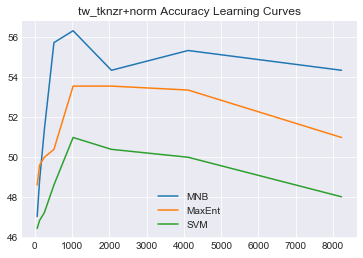

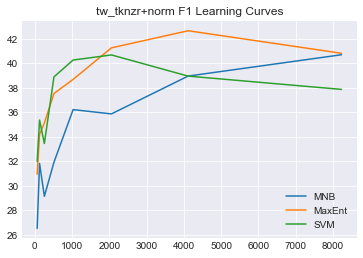

In [5]:
from sentiment.helpers import mytokenize


base_steps = [
    ('vect', CountVectorizer(tokenizer=mytokenize)),
]

name = "tw_tknzr+norm"

analysis.update(do_full_analysis(base_steps, clf_classes, name))


pd.DataFrame(analysis, )

Empeoró. Qué botonazo

##  Binario

MaxEnt
Sentiment P:
  Precision: 51.98% (118/227)
  Recall: 75.64% (118/156)
  F1: 61.62%
Sentiment N:
  Precision: 58.88% (126/214)
  Recall: 57.53% (126/219)
  F1: 58.20%
Sentiment NEU:
  Precision: 12.50% (2/16)
  Recall: 2.90% (2/69)
  F1: 4.71%
Sentiment NONE:
  Precision: 26.53% (13/49)
  Recall: 20.97% (13/62)
  F1: 23.42%
Accuracy: 51.19% (259/506)
Macro-Precision: 37.47%
Macro-Recall: 39.26%
Macro-F1: 38.35%
	P	N	NEU	NONE
P	118	28	4	6	
N	65	126	6	22	
NEU	29	30	2	8	
NONE	15	30	4	13	
MNB
Sentiment P:
  Precision: 48.11% (127/264)
  Recall: 81.41% (127/156)
  F1: 60.48%
Sentiment N:
  Precision: 59.17% (142/240)
  Recall: 64.84% (142/219)
  F1: 61.87%
Sentiment NEU:
  Precision: 0.00% (0/0)
  Recall: 0.00% (0/69)
  F1: 0.00%
Sentiment NONE:
  Precision: 50.00% (1/2)
  Recall: 1.61% (1/62)
  F1: 3.12%
Accuracy: 53.36% (270/506)
Macro-Precision: 39.32%
Macro-Recall: 36.97%
Macro-F1: 38.11%
	P	N	NEU	NONE
P	127	29	0	0	
N	76	142	0	1	
NEU	37	32	0	0	
NONE	24	37	0	1	
SVM
Sentiment P:
  P

,base_MNB,base_MaxEnt,base_SVM,binary_MNB,binary_MaxEnt,binary_SVM,tw_tknzr+norm_MNB,tw_tknzr+norm_MaxEnt,tw_tknzr+norm_SVM,tw_tknzr_MNB,tw_tknzr_MaxEnt,tw_tknzr_SVM
accuracy,53.755,52.569,50.395,53.360,51.186,50.395,54.348,50.988,48.024,55.138,51.383,49.407
macro-f1,40.321,39.870,40.022,38.106,38.346,40.299,40.699,40.818,37.869,44.292,40.912,39.451
macro-precision,43.625,39.397,39.157,39.318,37.473,39.556,43.921,41.148,37.168,52.454,41.450,38.750
macro-recall,37.483,40.354,40.926,36.966,39.260,41.070,37.918,40.494,38.597,38.328,40.387,40.176


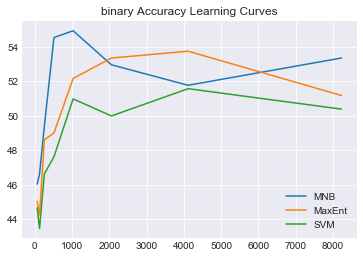

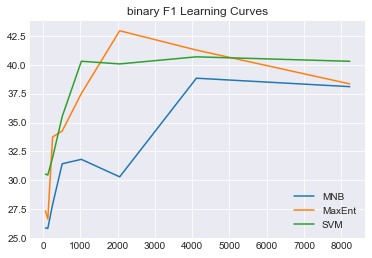

In [6]:
base_steps = [
    ('vect', CountVectorizer(
        #tokenizer=TweetTokenizer().tokenize, 
        binary=True)),
]

name = "binary"

analysis.update(do_full_analysis(base_steps, clf_classes, name))


pd.DataFrame(analysis)

# Stopwords

In [7]:
from nltk.corpus import stopwords


MaxEnt
Sentiment P:
  Precision: 47.86% (112/234)
  Recall: 71.79% (112/156)
  F1: 57.44%
Sentiment N:
  Precision: 61.46% (126/205)
  Recall: 57.53% (126/219)
  F1: 59.43%
Sentiment NEU:
  Precision: 21.43% (3/14)
  Recall: 4.35% (3/69)
  F1: 7.23%
Sentiment NONE:
  Precision: 32.08% (17/53)
  Recall: 27.42% (17/62)
  F1: 29.57%
Accuracy: 50.99% (258/506)
Macro-Precision: 40.71%
Macro-Recall: 40.27%
Macro-F1: 40.49%
	P	N	NEU	NONE
P	112	30	2	12	
N	68	126	6	19	
NEU	33	28	3	5	
NONE	21	21	3	17	
MNB
Sentiment P:
  Precision: 43.24% (128/296)
  Recall: 82.05% (128/156)
  F1: 56.64%
Sentiment N:
  Precision: 59.79% (116/194)
  Recall: 52.97% (116/219)
  F1: 56.17%
Sentiment NEU:
  Precision: 20.00% (1/5)
  Recall: 1.45% (1/69)
  F1: 2.70%
Sentiment NONE:
  Precision: 54.55% (6/11)
  Recall: 9.68% (6/62)
  F1: 16.44%
Accuracy: 49.60% (251/506)
Macro-Precision: 44.40%
Macro-Recall: 36.54%
Macro-F1: 40.08%
	P	N	NEU	NONE
P	128	25	1	2	
N	100	116	2	1	
NEU	41	25	1	2	
NONE	27	28	1	6	
SVM
Sentiment P

,base_MNB,base_MaxEnt,base_SVM,binary_MNB,binary_MaxEnt,binary_SVM,stopwords_MNB,stopwords_MaxEnt,stopwords_SVM,tw_tknzr+norm_MNB,tw_tknzr+norm_MaxEnt,tw_tknzr+norm_SVM,tw_tknzr_MNB,tw_tknzr_MaxEnt,tw_tknzr_SVM
accuracy,53.755,52.569,50.395,53.360,51.186,50.395,49.605,50.988,46.443,54.348,50.988,48.024,55.138,51.383,49.407
macro-f1,40.321,39.870,40.022,38.106,38.346,40.299,40.084,40.490,37.480,40.699,40.818,37.869,44.292,40.912,39.451
macro-precision,43.625,39.397,39.157,39.318,37.473,39.556,44.396,40.708,36.897,43.921,41.148,37.168,52.454,41.450,38.750
macro-recall,37.483,40.354,40.926,36.966,39.260,41.070,36.537,40.274,38.083,37.918,40.494,38.597,38.328,40.387,40.176


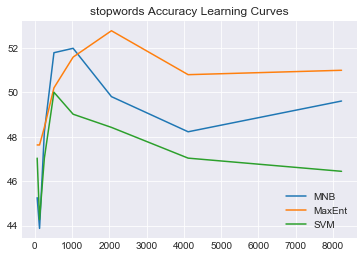

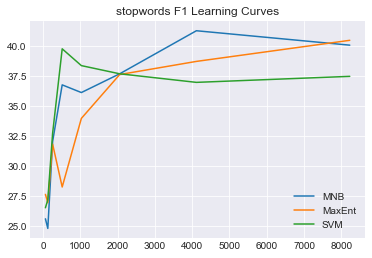

In [8]:
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

spanish_stopwords = stopwords.words('spanish')
spanish_stopwords += [strip_accents(w) for w in spanish_stopwords] 

base_steps = [
    ('vect', CountVectorizer(
        #tokenizer=TweetTokenizer().tokenize,
        #binary=True,
        stop_words=spanish_stopwords)),
]

name = "stopwords"

analysis.update(do_full_analysis(base_steps, clf_classes, name))


pd.DataFrame(analysis)